# Plot alignment

We plot ground truth dataset's relationship between acceleration and velocity difference.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import Batch, Data, DataLoader

In [3]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [63]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets

## Data

In [5]:
dataset = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic.pt",
    weights_only=False,
)
species_configs = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_config.pt",
    weights_only=False,
)

In [42]:
dataset_weak = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_weak_alignment.pt",
    weights_only=False,
)
species_configs_weak = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_weak_alignment_config.pt",
    weights_only=False,
)

In [43]:
dataset_strong = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_strong_alignment.pt",
    weights_only=False,
)
species_configs_strong = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_strong_alignment_config.pt",
    weights_only=False,
)

In [97]:
print(f"alignment factor for weak, median, and strong: {
                                                       species_configs_weak["A"]['matching_factor'],
                                                       species_configs["A"]['matching_factor'],
                                                       species_configs_strong["A"]['matching_factor'],
                                                       }"
     )

matching factor for weak, median, and strong: (0.1, 0.5, 1)


In [7]:
# split data into training set and test set
test_size = int(len(dataset) / 2)
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

# split data into training set and test set
train_dataset_weak, test_dataset_weak = random_split(
    dataset_weak, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

# split data into training set and test set
train_dataset_strong, test_dataset_strong = random_split(
    dataset_strong, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

In [46]:
# create mini-batches
batch_size = 1
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
test_loader = DataLoader(test_dataset,
                         batch_size = batch_size, shuffle=False)

test_loader_weak = DataLoader(test_dataset_weak,
                         batch_size = batch_size, shuffle=False)

test_loader_strong = DataLoader(test_dataset_strong,
                         batch_size = batch_size, shuffle=False)

batch = list(iter(test_loader))[0]
pos, species = batch

print("made", str(len(list(test_loader))), "batches, each of size", str(batch_size))  #
print(
    "Batch position:", pos.shape
)  # [Batch size, Number of boids, coordinates (x,y pos)= 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 25 batches, each of size 1
Batch position: torch.Size([1, 1000, 20, 2])
Species labels: torch.Size([1, 20])




## Load models

In [53]:
# load various models
models = {}

# model 1
old_name = "vpluspplus_a"
new_name = "no noise"
model_path = f"/workspace/collab-environment/collab_env/gnn/trained_models/boid_single_species_{old_name}_basic_special_frames.pt"
model = load_model(new_name, model_path)
models[new_name] = model

In [55]:
# do rollout
torch.cuda.empty_cache()
dataloader_list = list(test_loader)
visual_range = 0.5

training = False
epoch_num = 1
lr = None
rollout = 5
prediction_integration = "Euler"

m = models[new_name]

(node_feature_function,
 node_prediction,
 input_differentiation,
 prediction_integration,
 in_node_dim,
 start_frame
) = (m["node_feature_function"],
     m["node_prediction"],
     m["input_differentiation"],
     prediction_integration,
     m["in_node_dim"],
     m["start_frame"]
    )

gnn_model = m["model"]

epoch 0


batch 0




/workspace/collab-environment/collab_env/gnn/gnn.py:327: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/workspace/collab-environment/collab_env/gnn/gnn.py:328: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/workspace/collab-environment/collab_env/gnn/gnn.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.tensor(acc)
/workspace/collab-environment/collab_env/gnn/gnn.py:391: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or so

batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 13265359501502533347573760.0000
finished one epoch


In [ ]:
# train models
(m["rollout_losses"], _, m["rollout_debug_result"]) = train_rules_gnn(
    gnn_model,
    test_loader,
    visual_range=visual_range,
    epochs=epoch_num,
    lr=lr,
    training=training,
    species_dim=len(torch.unique(species)),
    device=None,
    rollout = rollout,
    )

In [98]:
# train models
(m["rollout_losses_weak"], _, m["rollout_debug_result_weak"]) = train_rules_gnn(
    gnn_model,
    test_loader_weak,
    visual_range=visual_range,
    epochs=epoch_num,
    lr=lr,
    training=training,
    species_dim=len(torch.unique(species)),
    device=None,
    rollout = rollout,
    )

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 6934305875.7541
finished one epoch


In [81]:
# train models
(m["rollout_losses_strong"], _, m["rollout_debug_result_strong"]) = train_rules_gnn(
    gnn_model,
    test_loader_strong,
    visual_range=visual_range,
    epochs=epoch_num,
    lr=lr,
    training=training,
    species_dim=len(torch.unique(species)),
    device=None,
    rollout = rollout,
    )

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 4618514.0818
finished one epoch


In [61]:
def rollout_to_pos_vel_acc(rollout_debug_result, starting_frame = 0, ending_frame = 50):
    pos_all_files = []
    vel_all_files = []
    acc_all_files = []
    
    for file_id in rollout_debug_result[0]:
        pos, vel, acc, pos_gnn, vel_gnn, acc_gnn, frame_sets = debug_result2prediction(
                            rollout_debug_result,
                            file_id = file_id, epoch_num = 0)
        
        pos_all_files.append(pos[0,starting_frame:ending_frame])
        vel_all_files.append(vel[0,starting_frame:ending_frame])
        acc_all_files.append(acc[0,starting_frame:ending_frame])
        
    pos_concatenated = torch.concatenate(pos_all_files)
    vel_concatenated = torch.concatenate(vel_all_files)
    acc_concatenated = torch.concatenate(acc_all_files)

    return pos_concatenated, vel_concatenated, acc_concatenated

In [102]:
def data_to_pos_vel_acc(loader, starting_frame = 0, ending_frame = 50):
    pos_all_files = []
    vel_all_files = []
    acc_all_files = []
    
    for (position_gt, _) in loader:
        
        pos, vel, acc, v_function = handle_discrete_data(position_gt, "Euler")
        
        pos_all_files.append(pos[0,starting_frame:ending_frame])
        vel_all_files.append(vel[0,starting_frame:ending_frame])
        acc_all_files.append(acc[0,starting_frame:ending_frame])
    
    pos_concatenated = torch.concatenate(pos_all_files)
    vel_concatenated = torch.concatenate(vel_all_files)
    acc_concatenated = torch.concatenate(acc_all_files)

    return pos_concatenated, vel_concatenated, acc_concatenated

In [99]:
def return_deltav_acc(pos, vel, acc):
    pos = pos.squeeze()
    vel = vel.squeeze()
    acc = acc.squeeze()
    F, N, dim = pos.shape

    del_v = []
    acc_ = []
    for f in range(F):
        for bi in range(N):
            for bj in range(N):
                if bj == bi:
                    continue
                if torch.norm(pos[f,bi] - pos[f,bj]) < 0.01:
                    del_v.append( torch.norm(vel[f,bi] - vel[f,bj]) )
                    acc_.append( torch.norm(acc[f,bi] ) )
    return del_v, acc_

In [21]:
def mean_traces(del_v, acc_):
    bins = np.linspace(0,0.05,10) # Bin edge
    indices = np.digitize(del_v, bins)
    indices_set = np.unique(indices)
    bins = bins[indices_set-1]
    
    mean = []
    sd = []
    for s in indices_set:
        mean.append( np.mean(np.array(acc_)[indices == s]) )
        sd.append( np.std(np.array(acc_)[indices == s]) )
    mean = np.array(mean)
    sd = np.array(sd)

    return bins, mean, sd

In [103]:
def figure_data(test_loader, rollout_debug_result, model = False, starting_frame = 5, ending_frame = 50):
    if model:
        (pos_concatenated, vel_concatenated, acc_concatenated) = rollout_to_pos_vel_acc(
            rollout_debug_result, starting_frame, ending_frame)
    else:
        (pos_concatenated, vel_concatenated, acc_concatenated) = data_to_pos_vel_acc(test_loader,
                                                                                    starting_frame,
                                                                                    ending_frame)

    del_v, acc_ = return_deltav_acc(pos_concatenated,
                                    vel_concatenated,
                                    acc_concatenated)
    return del_v, acc_

In [104]:
del_v, acc_ = figure_data(test_loader, None)
bins, mean, sd = mean_traces(del_v, acc_)

del_v_weak, acc_weak = figure_data(test_loader_weak, None)
bins_weak, mean_weak, sd_weak = mean_traces(del_v_weak, acc_weak)

del_v_strong, acc_strong = figure_data(test_loader_strong, None)
bins_strong, mean_strong, sd_strong = mean_traces(del_v_strong, acc_strong)

In [105]:
del_v_model, acc_model = figure_data(None, m["rollout_debug_result"],
                                     model = True, starting_frame = 5, ending_frame = 50)
bins_model, mean_model, sd_model = mean_traces(del_v_model, acc_model)

del_v_model_weak, acc_model_weak = figure_data(None, m["rollout_debug_result_weak"],
                                     model = True, starting_frame = 5, ending_frame = 50)
bins_model_weak, mean_model_weak, sd_model_weak = mean_traces(del_v_model_weak, acc_model_weak)

del_v_model_strong, acc_model_strong = figure_data(None, m["rollout_debug_result_strong"],
                                     model = True, starting_frame = 5, ending_frame = 50)
bins_model_strong, mean_model_strong, sd_model_strong = mean_traces(del_v_model_strong, acc_model_strong)

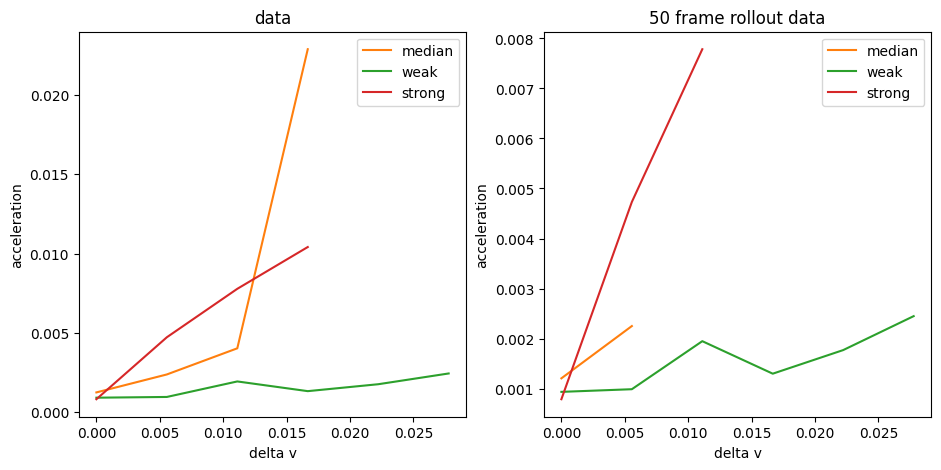

In [106]:
fig, axes = plt.subplots(1,2,figsize=(11, 5))
#ax.scatter(del_v, acc_, s = 5, alpha = 0.5)

ax = axes[0]
ax.plot(bins, mean, 'C1', label = "median")
ax.plot(bins_weak, mean_weak, 'C2', label = "weak")
ax.plot(bins_strong, mean_strong, 'C3', label = "strong")

ax2 = axes[1]
ax2.plot(bins_model, mean_model, 'C1', label = "median")
ax2.plot(bins_model_weak, mean_model_weak, 'C2', label = "weak")
ax2.plot(bins_model_strong, mean_model_strong, 'C3', label = "strong")

#ax.fill_between(bins, mean - sd, mean + sd, alpha = 0.5)
#ax.fill_between(bins_weak, mean_weak - sd_weak, mean_weak + sd_weak, alpha = 0.5)
ax.set_title("data")
ax2.set_title("50 frame rollout data")
ax.set_xlabel("delta v")
ax2.set_xlabel("delta v")

ax.set_ylabel("acceleration")
ax2.set_ylabel("acceleration")

ax.legend()
ax2.legend()

plt.show()
